# EMG recording
## Experiment 1: Large muscle experiment with dry and wet electrode

In [1]:
import wave
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def read_wave(file_name):
    file = wave.open(file_name,'rb')
    params = file.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    print("nchannels:", nchannels)
    print("sampwidth:", sampwidth)
    print("framerate:", framerate)
    print("nframes:", nframes)
    strData = file.readframes(nframes)  # encoded in bytes
    file.close()
    waveData = np.frombuffer(strData, dtype=np.int16)  # convert to int16
    return waveData, framerate, nframes

In [3]:
def normalize_wave(signal, type_of_norm = "by_max"):
    if type_of_norm == "by_max":
        return signal / (np.max(np.abs(signal)))
    elif type_of_norm == "01":
        return (signal - np.min(signal)) / (np.max(signal)-np.min(signal))
    elif type_of_norm == "statistic":
        return signal - np.mean(signal) / np.std(signal)
    else:
        print("pls indicate right normalization method: 'by_max', '01', or 'statistic'")
    

In [4]:
def plot_wave(signal, framerate, nframes, title):
    time = np.arange(0, nframes) * (1.0 / framerate)
    plt.figure(figsize=(6, 3))
    plt.plot(time, signal)
    plt.xlabel("Time(s)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid('on')
    plt.show()

nchannels: 1
sampwidth: 2
framerate: 10000
nframes: 338007


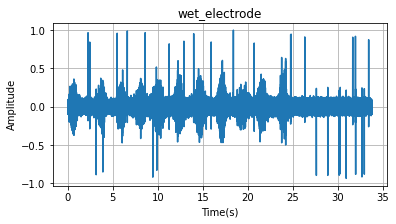

In [7]:
wet_signal, wet_framerate, wet_nframes = read_wave("实验1-湿电极贴片02.wav")
wet_signal_norm = normalize_wave(wet_signal)
plot_wave(wet_signal_norm, wet_framerate, wet_nframes, "wet_electrode")